In [6]:
import numpy as np
import pandas as pd

In [7]:
players = pd.read_csv('/Users/donovanmcmanus/Desktop/Machine_Learning/Final/Data/players.csv')
game_data = pd.read_csv('/Users/donovanmcmanus/Desktop/Machine_Learning/Final/Data/game.csv')
game_summary = pd.read_csv('/Users/donovanmcmanus/Desktop/Machine_Learning/Final/Data/game_summary.csv')
team = pd.read_csv('/Users/donovanmcmanus/Desktop/Machine_Learning/Final/Data/team.csv')
odds = pd.read_csv('/Users/donovanmcmanus/Desktop/Machine_Learning/Final/Data/oddsData.csv')

In [8]:
# Isolate games from 2013 season or later
game_summary['game_date_est'] = pd.to_datetime(game_summary['game_date_est'])
game_summary = game_summary[game_summary['game_date_est'] > pd.to_datetime('2013-09-30')]

game_data['game_date'] = pd.to_datetime(game_data['game_date'])
game_data = game_data[game_data['game_date'] > pd.to_datetime('2013-09-30')]

players = players[players['Season'] >= 2013]

In [9]:
data = game_summary[['game_id', 'home_team_id', 'visitor_team_id']]

# Remove games where the home team or visitor team is not in the team dataset
data = data[data['home_team_id'].isin(team['id'])]
data = data[data['visitor_team_id'].isin(team['id'])]

# Delete games where game_id does not exist in the game dataset
data = data[data['game_id'].isin(game_data['game_id'])]

In [10]:
# Add pts_home and pts_away to data from game dataset
game_summary = pd.merge(game_summary, game_data[['game_id', 'pts_home', 'pts_away']], on='game_id')
game_summary['total_points'] = game_summary['pts_home'] + game_summary['pts_away']

data = pd.merge(data, game_summary[['game_id', 'total_points']], on='game_id')

In [11]:
def last_10_point_performance(game_id, team_id, no_games=15):
    # Get the date of the specified game
    game_date = game_summary[game_summary['game_id'] == game_id]['game_date_est'].values[0]

    # Isolate only the games before the game in question
    previous_games = game_summary[game_summary['game_date_est'] < game_date]

    # Filter the games to include only those played by the specified team
    team_games = previous_games[(previous_games['home_team_id'] == team_id) | 
                                (previous_games['visitor_team_id'] == team_id)]
    
    # Sort the games by date in descending order
    team_games = team_games.sort_values('game_date_est', ascending=False)

    # Select 15 most recent games
    recent_games = team_games.head(no_games)

    # Calculate the total points scored by the team in those games
    total_points = 0
    for _, game in recent_games.iterrows():
        if game['home_team_id'] == team_id:
            total_points += game['pts_home']
        else:
            total_points += game['pts_away']

    # Calculate the average points scored
    if len(recent_games) >= no_games:
        average_points = total_points / len(recent_games)
    else:
        average_points = (game_summary['pts_home'].mean() + game_summary['pts_away'].mean()) / 2

    return average_points

In [12]:
def last_10_point_differential(game_id, team_id, no_games=15):
    # Get the date of the specified game
    game_date = game_summary[game_summary['game_id'] == game_id]['game_date_est'].values[0]

    # Isolate only the games before the game in question
    previous_games = game_summary[game_summary['game_date_est'] < game_date]
    
    # Filter the games to include only those played by the specified team
    team_games = previous_games[(previous_games['home_team_id'] == team_id) | 
                                (previous_games['visitor_team_id'] == team_id)]
    
    # Sort the games by date in descending order
    team_games = team_games.sort_values('game_date_est', ascending=False)

    # Select the most recent games
    recent_games = team_games.head(no_games)

    # Calculate the total points scored by the team in those games
    point_diff = 0
    for _, game in recent_games.iterrows():
        if game['home_team_id'] == team_id:
            point_diff += game['pts_home'] - game['pts_away']
        if game['visitor_team_id'] == team_id:
            point_diff += game['pts_away'] - game['pts_home']

    # Calculate the average points scored
    if len(recent_games) < no_games:
        point_diff = 0

    return point_diff / 15

In [13]:
def last_10_win_percentage(game_id, team_id, games=game_data, no_games=15):
    
    # Get the date of the specified game
    game_date = games[games['game_id'] == game_id]['game_date'].values[0]

    # Isolate only the games before the game in question
    games = games[games['game_date'] < game_date]

    # Filter the games to include only those played by the specified team
    games = games[(games['team_id_home'] == team_id) | 
                                (games['team_id_away'] == team_id)]

    # Sort the games by date in descending order
    games = games.sort_values('game_date', ascending=False)

    # Select the 15 most recent games
    recent_games = games.head(no_games)

    # Calculate the total points scored by the team in those games
    wins = 0
    for _, game in recent_games.iterrows():
        if game['team_id_home'] == team_id:
            wins += 1 if game['wl_home'] == 'W' else 0
        if game['team_id_away'] == team_id:
            wins += 1 if game['wl_away'] == 'W' else 0

    # Calculate the average points scored
    if len(recent_games) < no_games:
        wins = 0.5
    else:
        wins = wins / no_games

    return wins

In [14]:
def last_10_3point(game_id, team_id, games=game_data, no_games=15):

    # Get the date of the specified game
    game_date = games[games['game_id'] == game_id]['game_date'].values[0]

    # Isolate only the games before the game in question
    games = games[games['game_date'] < game_date]

    # Filter the games to include only those played by the specified team
    games = games[(games['team_id_home'] == team_id) | 
                                (games['team_id_away'] == team_id)]

    # Sort the games by date in descending order
    games = games.sort_values('game_date', ascending=False)

    # Select the 15 most recent games
    recent_games = games.head(no_games)

    # Calculate the total points scored by the team in those games
    three_point = 0
    for _, game in recent_games.iterrows():
        if game['team_id_home'] == team_id:
            three_point += game['fg3m_home']
        if game['team_id_away'] == team_id:
            three_point += game['fg3m_away']

    # Calculate the average points scored
    if len(recent_games) < no_games:
        three_point = (games['fg3m_home'].mean() + games['fg3m_away'].mean()) / 2
    else:
        three_point = three_point / no_games

    return three_point

In [15]:
def last_10_fgm(game_id, team_id, games=game_data, no_games=15):

    # Get the date of the specified game
    game_date = games[games['game_id'] == game_id]['game_date'].values[0]

    # Isolate only the games before the game in question
    games = games[games['game_date'] < game_date]

    # Filter the games to include only those played by the specified team
    games = games[(games['team_id_home'] == team_id) | 
                                (games['team_id_away'] == team_id)]

    # Sort the games by date in descending order
    games = games.sort_values('game_date', ascending=False)

    # Select the 10 most recent games
    recent_games = games.head(no_games)

    # Calculate the total points scored by the team in those games
    points = 0
    for _, game in recent_games.iterrows():
        if game['team_id_home'] == team_id:
            points += game['fgm_home']
        if game['team_id_away'] == team_id:
            points += game['fgm_away']

    # Calculate the average points scored
    if len(recent_games) < no_games:
        points = (games['fgm_home'].mean() + games['fgm_away'].mean()) / 2
    else:
        points = points / no_games

    return points

In [16]:
# Add new columns for home and visitor last 10 game performance
data['home_points_last_10'] = data.apply(lambda row: last_10_point_performance(row['game_id'], row['home_team_id']), axis=1)
data['visitor_points_last_10'] = data.apply(lambda row: last_10_point_performance(row['game_id'], row['visitor_team_id']), axis=1)
print('1/5')
# Add new columns for home and visitor last 10 game win percentage
data['home_win_percentage_last_10'] = data.apply(lambda row: last_10_win_percentage(row['game_id'], row['home_team_id']), axis=1)
data['visitor_win_percentage_last_10'] = data.apply(lambda row: last_10_win_percentage(row['game_id'], row['visitor_team_id']), axis=1)
print('2/5')
# Add new columns for home and visitor last 10 game point differential
data['home_point_diff_last_10'] = data.apply(lambda row: last_10_point_differential(row['game_id'], row['home_team_id']), axis=1)
data['visitor_point_diff_last_10'] = data.apply(lambda row: last_10_point_differential(row['game_id'], row['visitor_team_id']), axis=1)
print('3/5')
# Add new columns for home and visitor last 10 game 3 point shots made
data['home_3_point_last_10'] = data.apply(lambda row: last_10_3point(row['game_id'], row['home_team_id']), axis=1)
data['visitor_3_point_last_10'] = data.apply(lambda row: last_10_3point(row['game_id'], row['visitor_team_id']), axis=1)
print('4/5')
# Add new columns for home and visitor last 10 game fg shots made
data['home_fg_last_10'] = data.apply(lambda row: last_10_fgm(row['game_id'], row['home_team_id']), axis=1)
data['visitor_fg_last_10'] = data.apply(lambda row: last_10_fgm(row['game_id'], row['visitor_team_id']), axis=1)
print('5/5')

1/5
2/5
3/5
4/5
5/5


In [17]:
# Add the season column to the data
data = pd.merge(data, game_summary[['game_id', 'season']], on='game_id')
data2 = data.copy()

In [18]:
players.iloc[6540:6545]

,Unnamed: 0.1,Unnamed: 0,Season,Player,Pos,Age,Tm,G,GS,MP,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
28229,29340,833,2022,Gabe York,SG,28.0,IND,2.0,0.0,21.0,...,0.600,0.0,2.0,2.0,4.0,2.0,1.0,1.0,4.0,8.0
28230,29342,835,2022,Thaddeus Young,PF,33.0,TOT,52.0,1.0,845.0,...,0.469,80.0,128.0,208.0,104.0,54.0,18.0,52.0,81.0,322.0
28231,29343,836,2022,Thaddeus Young,PF,33.0,SAS,26.0,1.0,370.0,...,0.455,40.0,53.0,93.0,59.0,23.0,7.0,30.0,38.0,158.0
28232,29344,837,2022,Thaddeus Young,PF,33.0,TOR,26.0,0.0,475.0,...,0.481,40.0,75.0,115.0,45.0,31.0,11.0,22.0,43.0,164.0
28233,29345,838,2022,Trae Young,PG,23.0,ATL,76.0,76.0,2652.0,...,0.904,50.0,234.0,284.0,737.0,72.0,7.0,303.0,128.0,2155.0


In [19]:
import warnings
warnings.simplefilter("ignore")

# Add the team IDs to the players dataframe
players = pd.merge(players, team[['id', 'abbreviation']], left_on='Tm', right_on='abbreviation')
players.drop('Tm', axis=1, inplace=True)

# Manually OHE the players
for player in players['Player'].unique():
    data[player] = 0

data.head()

,game_id,home_team_id,visitor_team_id,total_points,home_points_last_10,visitor_points_last_10,home_win_percentage_last_10,visitor_win_percentage_last_10,home_point_diff_last_10,visitor_point_diff_last_10,...,Trendon Watford,Joe Wieskamp,Aaron Wiggins,Lindell Wigginton,Brandon Williams,Ziaire Williams,McKinley Wright IV,Moses Wright,Gabe York,Omer Yurtseven
0,21300003,1610612747,1610612746,219.0,107.184665,107.184665,0.5,0.5,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,21300001,1610612754,1610612753,184.0,107.184665,107.184665,0.5,0.5,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,21300002,1610612748,1610612741,202.0,107.184665,107.184665,0.5,0.5,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,21300010,1610612750,1610612753,235.0,107.184665,107.184665,0.5,0.5,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,21300013,1610612759,1610612763,195.0,107.184665,107.184665,0.5,0.5,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# KAM-IFIED VERSION
# Ensure all players are columns in the dataset
for player in players['Player']:
    if player not in data.columns:
        data[player] = 0

# Loop through players and update their participation in games
for _, player_row in players.iterrows():
    player_id = player_row['id']
    player_name = player_row['Player']
    player_season = player_row['Season']

    # Find relevant rows where this player participated during their season
    mask = (
        (data['season'] == player_season) &
        ((data['home_team_id'] == player_id) | (data['visitor_team_id'] == player_id))
    )

    # Set Column to 1
    data.loc[mask, player_name] = 1

data.head()

,game_id,home_team_id,visitor_team_id,total_points,home_points_last_10,visitor_points_last_10,home_win_percentage_last_10,visitor_win_percentage_last_10,home_point_diff_last_10,visitor_point_diff_last_10,...,Trendon Watford,Joe Wieskamp,Aaron Wiggins,Lindell Wigginton,Brandon Williams,Ziaire Williams,McKinley Wright IV,Moses Wright,Gabe York,Omer Yurtseven
0,21300003,1610612747,1610612746,219.0,107.184665,107.184665,0.5,0.5,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,21300001,1610612754,1610612753,184.0,107.184665,107.184665,0.5,0.5,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,21300002,1610612748,1610612741,202.0,107.184665,107.184665,0.5,0.5,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,21300010,1610612750,1610612753,235.0,107.184665,107.184665,0.5,0.5,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,21300013,1610612759,1610612763,195.0,107.184665,107.184665,0.5,0.5,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
nan_counts = data.isna().sum()
print(nan_counts[nan_counts > 0])

data = data.dropna()
data2 = data2.dropna()
nan_counts = data.isna().sum()
print(nan_counts[nan_counts > 0])

home_3_point_last_10       11
visitor_3_point_last_10    11
home_fg_last_10            11
visitor_fg_last_10         11
dtype: int64
Series([], dtype: int64)


In [22]:
# Only games from 2013 season or later
odds['date'] = pd.to_datetime(odds['date'])
odds = odds[odds['date'] > pd.to_datetime('2013-09-30')]
odds = odds[odds['home/visitor'] == 'vs']

In [23]:
# Team ID mapping
team_id_map = {
    'Atlanta': 1610612737, 'Boston': 1610612738, 'Cleveland': 1610612739, 'New Orleans': 1610612740,
    'Chicago': 1610612741, 'Dallas': 1610612742, 'Denver': 1610612743, 'Golden State': 1610612744,
    'Houston': 1610612745, 'LA Clippers': 1610612746, 'LA Lakers': 1610612747, 'Miami': 1610612748,
    'Milwaukee': 1610612749, 'Minnesota': 1610612750, 'Brooklyn': 1610612751, 'New York': 1610612752,
    'Orlando': 1610612753, 'Indiana': 1610612754, 'Philadelphia': 1610612755, 'Phoenix': 1610612756,
    'Portland': 1610612757, 'Sacramento': 1610612758, 'San Antonio': 1610612759, 'Oklahoma City': 1610612760,
    'Toronto': 1610612761, 'Utah': 1610612762, 'Memphis': 1610612763, 'Washington': 1610612764,
    'Detroit': 1610612765, 'Charlotte': 1610612766
}

def id(team, location, opponent):
    # Get team and opponent IDs
    team_id = team_id_map.get(team)
    opponent_id = team_id_map.get(opponent)
    
    # Determine home and visitor teams
    if location == 'vs':
        home_team_id = team_id
        visitor_team_id = opponent_id
    else:  # Assuming location == 'at'
        home_team_id = opponent_id
        visitor_team_id = team_id

    return home_team_id, visitor_team_id

# Apply the function to the dataframe
odds[['home_team_id', 'visitor_team_id']] = odds.apply(
    lambda row: pd.Series(id(row['team'], row['home/visitor'], row['opponent'])), axis=1
)

In [24]:
print(odds.shape)
odds.head()

(11507, 14)


,date,season,team,home/visitor,opponent,score,opponentScore,moneyLine,opponentMoneyLine,total,spread,secondHalfTotal,home_team_id,visitor_team_id
14278,2013-10-29,2014,Miami,vs,Chicago,107,95,-220.0,180.0,188.5,-5.0,93.5,1610612748,1610612741
14280,2013-10-29,2014,LA Lakers,vs,LA Clippers,116,103,435.0,-575.0,202.5,9.5,103.0,1610612747,1610612746
14283,2013-10-29,2014,Indiana,vs,Orlando,97,87,-1025.0,675.0,188.5,-12.0,94.5,1610612754,1610612753
14284,2013-10-30,2014,Dallas,vs,Atlanta,118,109,-245.0,205.0,196.0,-6.0,98.5,1610612742,1610612737
14285,2013-10-30,2014,Toronto,vs,Boston,93,87,-385.0,305.0,189.5,-8.0,93.5,1610612761,1610612738


In [25]:
# Actual total score
odds['total_points'] = odds['score'] + odds['opponentScore']

# Calculate the mean squared error
from sklearn.metrics import mean_squared_error
print('Sports Betting Mean Squared Error: ', mean_squared_error(odds['total_points'], odds['total']))

Sports Betting Mean Squared Error:  319.6472147388546


In [26]:
def find_game_id(home_team_id, visitor_team_id, date):

    # Convert the date to a datetime object
    date = pd.to_datetime(date)
    
    game_id = game_summary[(game_summary['home_team_id'] == home_team_id) & 
                           (game_summary['visitor_team_id'] == visitor_team_id) & 
                           (game_summary['game_date_est'].dt.year == date.year) &
                           (game_summary['game_date_est'].dt.month == date.month) & 
                           (game_summary['game_date_est'].dt.day == date.day)]
    
    # Check if any game_id is found and return it
    if not game_id.empty:
        return game_id['game_id'].iloc[0]
    else:
        return None

In [27]:
game_data['game_date'] = pd.to_datetime(game_summary['game_date_est'])
odds['game_id'] = odds.apply(lambda row: find_game_id(row['home_team_id'], row['visitor_team_id'], row['date']), axis=1)
odds.shape

(11507, 16)

In [28]:
# Count the occurrences of 'none' in the 'game_id' column
none_count = odds['game_id'].isna().sum()
print(f"'NaN' appears {none_count} times in the 'game_id' column.")

'NaN' appears 1108 times in the 'game_id' column.


In [29]:
odds.head()

,date,season,team,home/visitor,opponent,score,opponentScore,moneyLine,opponentMoneyLine,total,spread,secondHalfTotal,home_team_id,visitor_team_id,total_points,game_id
14278,2013-10-29,2014,Miami,vs,Chicago,107,95,-220.0,180.0,188.5,-5.0,93.5,1610612748,1610612741,202,21300002.0
14280,2013-10-29,2014,LA Lakers,vs,LA Clippers,116,103,435.0,-575.0,202.5,9.5,103.0,1610612747,1610612746,219,21300003.0
14283,2013-10-29,2014,Indiana,vs,Orlando,97,87,-1025.0,675.0,188.5,-12.0,94.5,1610612754,1610612753,184,21300001.0
14284,2013-10-30,2014,Dallas,vs,Atlanta,118,109,-245.0,205.0,196.0,-6.0,98.5,1610612742,1610612737,227,NaN
14285,2013-10-30,2014,Toronto,vs,Boston,93,87,-385.0,305.0,189.5,-8.0,93.5,1610612761,1610612738,180,21300006.0


In [30]:
# Delete rows where game_id is null
odds = odds.dropna(subset=['game_id'])
odds.shape

(10399, 16)

In [31]:
# One-hot encode the home and visitor team IDs
data = pd.get_dummies(data, columns = ['home_team_id', 'visitor_team_id'], dtype=int)
data2 = pd.get_dummies(data2, columns = ['home_team_id', 'visitor_team_id'], dtype=int)

# OHE the season column
data = pd.get_dummies(data, columns = ['season'], dtype=int)

In [32]:
# WITHOUT PLAYERS OR SEASONS
# -------------------------------------------------------
# Define a linear regression model - Lasso
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
y = data2['total_points']
X = data2.drop(['game_id', 'total_points'], axis=1)
print('Size of X:', X.shape), print()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = Lasso(alpha=0.08)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'LASSO - Mean Squared Error: {mse}')

# Get the coefficients of the model
coefficients = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
coefficients = coefficients.sort_values('coefficient', ascending=False)
print(coefficients.head(10)), print()

# -------------------------------------------------------
# Define a linear regression model - ElasticNet
from sklearn.linear_model import ElasticNet

# Train the model
model = ElasticNet(alpha=0.08, l1_ratio=0.5)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'ELASTICNET - Mean Squared Error: {mse}')

# Get the coefficients of the model
coefficients = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
coefficients = coefficients.sort_values('coefficient', ascending=False)
print(coefficients.head(10)), print()

# -------------------------------------------------------
# Define a linear regression model - Random Forrest
from sklearn.ensemble import RandomForestRegressor

# Train the model
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'RANDOM FORREST - Mean Squared Error: {mse}')

Size of X: (12660, 71)

LASSO - Mean Squared Error: 341.8744830528064
                       feature  coefficient
54  visitor_team_id_1610612750     3.518066
49  visitor_team_id_1610612745     1.964671
19     home_team_id_1610612745     1.367973
9           visitor_fg_last_10     1.019573
8              home_fg_last_10     0.777664
17     home_team_id_1610612743     0.765956
0          home_points_last_10     0.706758
1       visitor_points_last_10     0.559672
31     home_team_id_1610612757     0.505520
55  visitor_team_id_1610612751     0.418544

ELASTICNET - Mean Squared Error: 341.36261891597366
                       feature  coefficient
54  visitor_team_id_1610612750     2.045622
49  visitor_team_id_1610612745     1.356145
19     home_team_id_1610612745     1.131739
9           visitor_fg_last_10     1.004421
17     home_team_id_1610612743     0.897288
8              home_fg_last_10     0.776859
31     home_team_id_1610612757     0.759344
55  visitor_team_id_1610612751     0.7006

In [33]:
# WITH PLAYERS AND SEASONS OHE
# -------------------------------------------------------
# Define a linear regression model - Lasso
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
y = data['total_points']
X = data.drop(['game_id', 'total_points'], axis=1)
print('Size of X:', X.shape), print()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = Lasso(alpha=0.08)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'LASSO - Mean Squared Error: {mse}')

# Get the coefficients of the model
coefficients = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
coefficients = coefficients.sort_values('coefficient', ascending=False)
print(coefficients.head(10)), print()

# -------------------------------------------------------
# Define a linear regression model - ElasticNet
from sklearn.linear_model import ElasticNet

# Train the model
model = ElasticNet(alpha=0.08, l1_ratio=0.5)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'ELASTICNET - Mean Squared Error: {mse}')

# Get the coefficients of the model
coefficients = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
coefficients = coefficients.sort_values('coefficient', ascending=False)
print(coefficients.head(10)), print()

# -------------------------------------------------------
# Define a linear regression model - Random Forrest
from sklearn.ensemble import RandomForestRegressor

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'RANDOM FORREST - Mean Squared Error: {mse}')

Size of X: (12660, 1409)

LASSO - Mean Squared Error: 335.71737728922005
                         feature  coefficient
227               Terrence Jones     2.684829
1382  visitor_team_id_1610612750     2.451659
136             Danilo Gallinari     2.391103
829                 Tyler Dorsey     1.579116
187                 Jrue Holiday     1.254851
470                 Gorgui Dieng     1.209572
95              Dante Cunningham     1.185006
676                 Jordan McRae     1.124770
389              Marcus Thornton     1.093074
228               DeAndre Jordan     1.027123

ELASTICNET - Mean Squared Error: 333.29549658795725
                         feature  coefficient
1382  visitor_team_id_1610612750     1.381096
136             Danilo Gallinari     1.294233
227               Terrence Jones     1.248637
470                 Gorgui Dieng     1.122813
95              Dante Cunningham     1.057735
187                 Jrue Holiday     1.009777
290           Donatas Motiejūnas     0.982505


In [34]:
data.head()

,game_id,total_points,home_points_last_10,visitor_points_last_10,home_win_percentage_last_10,visitor_win_percentage_last_10,home_point_diff_last_10,visitor_point_diff_last_10,home_3_point_last_10,visitor_3_point_last_10,...,season_2013,season_2014,season_2015,season_2016,season_2017,season_2018,season_2019,season_2020,season_2021,season_2022
0,21300003,219.0,107.184665,107.184665,0.5,0.5,0.0,0.0,8.000000,7.312500,...,1,0,0,0,0,0,0,0,0,0
1,21300001,184.0,107.184665,107.184665,0.5,0.5,0.0,0.0,6.750000,7.375000,...,1,0,0,0,0,0,0,0,0,0
2,21300002,202.0,107.184665,107.184665,0.5,0.5,0.0,0.0,8.812500,5.500000,...,1,0,0,0,0,0,0,0,0,0
3,21300010,235.0,107.184665,107.184665,0.5,0.5,0.0,0.0,7.642857,7.444444,...,1,0,0,0,0,0,0,0,0,0
4,21300013,195.0,107.184665,107.184665,0.5,0.5,0.0,0.0,8.785714,5.312500,...,1,0,0,0,0,0,0,0,0,0


In [35]:
# -------------------------------------------------------
from sklearn.linear_model import ElasticNet

# Split the data
random_game_ids = odds['game_id'].sample(n=1000, random_state=42).values

# First, filter the main dataset to only include rows where 'game_id' is in the odds dataset
testing_data = data[data['game_id'].isin(random_game_ids)]
# The remaining data will be used as the training set
training_data = data[~data['game_id'].isin(odds['game_id'])]

# Separate features and target
X_train = training_data.drop(['game_id', 'total_points'], axis=1)
y_train = training_data['total_points']
X_test = testing_data.drop(['game_id', 'total_points'], axis=1)
y_test = testing_data['total_points']

# Train the model
model = ElasticNet(alpha=0.08, l1_ratio=0.5)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [36]:
# Add the predictions to the test_data dataframe
testing_data['predicted_total_points'] = y_pred

# Merge the test_data with the odds dataset
testing_data = pd.merge(testing_data, odds[['game_id', 'total_points', 'total']], on='game_id')

In [37]:
relevant_data = testing_data[['game_id', 'total_points_x', 'predicted_total_points', 'total']]
relevant_data = relevant_data.dropna()
relevant_data = relevant_data.rename(columns={
    'game_id': 'game_id',
    'total_points_x': 'total_points_actual',
    'predicted_total_points': 'total_points_predicted',
    'total': 'over_under_line'
})
print(relevant_data.shape)
relevant_data.head()

(1007, 4)


,game_id,total_points_actual,total_points_predicted,over_under_line
0,21300006,180.0,189.106978,189.5
1,21300015,195.0,196.831343,197.5
2,21300017,219.0,197.319918,206.0
3,21300039,220.0,206.057615,198.5
4,21300036,210.0,192.380554,194.5


In [38]:
# Calculate accuracy

counter = 0
for index, row in relevant_data.iterrows():
    if row['total_points_predicted'] > row['over_under_line'] and row['total_points_actual'] > row['over_under_line']:
        counter += 1
    if row['total_points_predicted'] < row['over_under_line'] and row['total_points_actual'] < row['over_under_line']:
        counter += 1
accuracy = counter / relevant_data.shape[0]

print(f'Accuracy: {accuracy}')

Accuracy: 0.5044687189672294


In [39]:
# Accuracy calculation function
def calculate_accuracy(predictions):
    counter = 0
    for index, row in predictions.iterrows():
        if row['total_points_predicted'] > row['over_under_line'] and row['total_points_actual'] > row['over_under_line']:
            counter += 1
        if row['total_points_predicted'] < row['over_under_line'] and row['total_points_actual'] < row['over_under_line']:
            counter += 1
    accuracy = counter / len(predictions)
    return accuracy

In [40]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Tuning for a single model
def tune_single_model(model_name, model, params, X_train, y_train, X_test, y_test, odds_data, test_data, debug):
    print(f"Tuning {model_name}...")
    
    scores = []
    accuracies = []
    hyperparameters = []
    best_accuracy = -float('inf')
    best_params = None
    
    # # Standardize features
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_test_scaled = scaler.transform(X_test)
    
    for param_set in params:
        if debug:
            print(f"Trying Param Set {param_set}...")
        
        model.set_params(**param_set)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Merge prediction with test data
        test_data_copy = test_data.copy()
        test_data_copy['predicted_total_points'] = y_pred
        test_data_copy = pd.merge(test_data_copy, odds_data[['game_id', 'total_points', 'total']], on='game_id', how='left')
        
        # Calculate performance (Accuracy, MSE, R^2)
        relevant_data = test_data_copy[['game_id', 'total_points_x', 'predicted_total_points', 'total']].dropna()
        relevant_data = relevant_data.rename(columns={
            'game_id': 'game_id',
            'total_points_x': 'total_points_actual',
            'predicted_total_points': 'total_points_predicted',
            'total': 'over_under_line'
        })
        
        # Calculate accuracy
        accuracy = calculate_accuracy(relevant_data)
        
        # Calculate R2 and MSE
        mse = mean_squared_error(relevant_data['total_points_actual'], relevant_data['total_points_predicted'])
        r2 = r2_score(relevant_data['total_points_actual'], relevant_data['total_points_predicted'])
        
        accuracies.append(accuracy)
        scores.append({'MSE': mse, 'R2': r2})
        hyperparameters.append(param_set)
        
        # Check for best accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = param_set
        
        if debug:
            print(f"Accuracy for {param_set}: {accuracy}, MSE: {mse}, R^2: {r2}")

    # Print the best combination of hyperparameters
    print(f"Best Params for {model_name}: {best_params} with Accuracy: {best_accuracy}")
    
    return accuracies, scores, hyperparameters


# Model tuning function for multiple models
def tune_models(data, y_col, models_params, odds, debug):
    results = []
    
    # Split the data by random game IDs for testing and training
    random_game_ids = odds['game_id'].sample(n=1000, random_state=42).values

    testing_data = data[data['game_id'].isin(random_game_ids)]
    training_data = data[~data['game_id'].isin(random_game_ids)]

    # Separate features and target for training and testing
    X_train = training_data.drop(['game_id', y_col], axis=1)
    y_train = training_data[y_col]
    X_test = testing_data.drop(['game_id', y_col], axis=1)
    y_test = testing_data[y_col]

    # Tune each model
    for model_name, (model, params) in models_params.items():
        accuracies, scores, hyperparameters = tune_single_model(model_name, model, params, X_train, y_train, X_test, y_test, odds, testing_data, debug)
        results.append({
            'Model': model_name,
            'Accuracies': accuracies,
            'Scores': scores,  # has the MSE and R^2
            'Hyperparameters': hyperparameters
        })

    return results

2024-12-19 13:32:01 [matplotlib] DEBUG: matplotlib data path: /opt/anaconda3/lib/python3.12/site-packages/matplotlib/mpl-data
2024-12-19 13:32:01 [matplotlib] DEBUG: CONFIGDIR=/Users/donovanmcmanus/.matplotlib
2024-12-19 13:32:01 [matplotlib] DEBUG: interactive is False
2024-12-19 13:32:01 [matplotlib] DEBUG: platform is darwin
2024-12-19 13:32:01 [matplotlib] DEBUG: CACHEDIR=/Users/donovanmcmanus/.matplotlib
2024-12-19 13:32:01 [matplotlib.font_manager] DEBUG: Using fontManager instance from /Users/donovanmcmanus/.matplotlib/fontlist-v330.json


In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(results):
    for result in results:
        if result['Model'] == 'ElasticNet':
            # ElasticNet: Alpha vs Accuracy for different L1 Ratios
            accuracy_dict = {}
            for acc, params in zip(result['Accuracies'], result['Hyperparameters']):
                alpha = params['alpha']
                l1_ratio = params['l1_ratio']
                accuracy_dict[(alpha, l1_ratio)] = acc

            alphas = sorted(set([params['alpha'] for params in result['Hyperparameters']]))
            l1_ratios = sorted(set([params['l1_ratio'] for params in result['Hyperparameters']]))

            plt.figure(figsize=(10, 6))
            for l1_ratio in l1_ratios:
                accuracies = [accuracy_dict[(alpha, l1_ratio)] for alpha in alphas]
                plt.plot(alphas, accuracies, marker='o', label=f'L1 Ratio = {l1_ratio}')

            plt.xlabel('Alpha')
            plt.ylabel('Accuracy')
            plt.title('ElasticNet: Alpha vs Accuracy for Different L1 Ratios')
            plt.grid(True)
            plt.legend(title="L1 Ratio")
            plt.show()

        elif result['Model'] == 'Lasso':
            param_values = [p['alpha'] for p in result['Hyperparameters']]
            plt.figure(figsize=(10, 6))
            plt.plot(param_values, result['Accuracies'], marker='o', linestyle='-', color='b', label=f'{result["Model"]} Alpha vs Accuracy')
            plt.xlabel('Alpha')
            plt.ylabel('Accuracy')
            plt.title(f'{result["Model"]} Alpha vs Accuracy')
            plt.grid(True)
            plt.legend()
            plt.show()

        elif result['Model'] == 'Ridge':
            param_values = [p['alpha'] for p in result['Hyperparameters']]
            plt.figure(figsize=(10, 6))
            plt.plot(param_values, result['Accuracies'], marker='o', linestyle='-', color='g', label=f'{result["Model"]} Alpha vs Accuracy')
            plt.xlabel('Alpha')
            plt.ylabel('Accuracy')
            plt.title(f'{result["Model"]} Alpha vs Accuracy')
            plt.grid(True)
            plt.legend()
            plt.show()

        elif result['Model'] == 'RandomForest':
            n_estimators_values = [p['n_estimators'] for p in result['Hyperparameters']]
            max_depth_values = sorted(set(p['max_depth'] for p in result['Hyperparameters'] if p['max_depth'] is not None))

            plt.figure(figsize=(10, 6))
            for max_depth in max_depth_values:
                filtered_accuracies = [acc for p, acc in zip(result['Hyperparameters'], result['Accuracies']) if p['max_depth'] == max_depth]
                filtered_n_estimators = [p['n_estimators'] for p in result['Hyperparameters'] if p['max_depth'] == max_depth]
                plt.plot(filtered_n_estimators, filtered_accuracies, marker='o', label=f'Max Depth = {max_depth}')

            plt.xlabel('N Estimators')
            plt.ylabel('Accuracy')
            plt.title(f'{result["Model"]} N Estimators vs Accuracy (for different Max Depths)')
            plt.grid(True)
            plt.legend(title='Max Depth')
            plt.show()

        elif result['Model'] == 'GradientBoosting':
            n_estimators_values = [p['n_estimators'] for p in result['Hyperparameters']]
            max_depth_values = sorted(set(p['max_depth'] for p in result['Hyperparameters'] if p['max_depth'] is not None))

            plt.figure(figsize=(10, 6))
            for max_depth in max_depth_values:
                filtered_accuracies = [acc for p, acc in zip(result['Hyperparameters'], result['Accuracies']) if p['max_depth'] == max_depth]
                filtered_n_estimators = [p['n_estimators'] for p in result['Hyperparameters'] if p['max_depth'] == max_depth]
                plt.plot(filtered_n_estimators, filtered_accuracies, marker='o', label=f'Max Depth = {max_depth}')

            plt.xlabel('N Estimators')
            plt.ylabel('Accuracy')
            plt.title(f'{result["Model"]} N Estimators vs Accuracy (for different Max Depths)')
            plt.grid(True)
            plt.legend(title='Max Depth')
            plt.show()

        elif result['Model'] == 'SVR':
            param_values = [p['C'] for p in result['Hyperparameters']]
            epsilons = sorted(set([p['epsilon'] for p in result['Hyperparameters']]))
            plt.figure(figsize=(10, 6))
            for epsilon in epsilons:
                filtered_accuracies = [acc for p, acc in zip(result['Hyperparameters'], result['Accuracies']) if p['epsilon'] == epsilon]
                plt.plot(param_values, filtered_accuracies, marker='o', label=f'Epsilon = {epsilon}')
            plt.xlabel('C')
            plt.ylabel('Accuracy')
            plt.title(f'{result["Model"]} C vs Accuracy (for different Epsilons)')
            plt.grid(True)
            plt.legend(title="Epsilon")
            plt.show()

        elif result['Model'] == 'KNN':
            param_values = [p['n_neighbors'] for p in result['Hyperparameters']]
            plt.figure(figsize=(10, 6))
            plt.plot(param_values, result['Accuracies'], marker='o', linestyle='-', label='KNN K vs Accuracy')
            plt.xlabel('K (Neighbors)')
            plt.ylabel('Accuracy')
            plt.title('KNN K vs Accuracy')
            plt.grid(True)
            plt.legend()
            plt.show()

        elif result['Model'] == 'MLP':
            param_values = [p['hidden_layer_sizes'] for p in result['Hyperparameters']]
            plt.figure(figsize=(10, 6))
            plt.plot(param_values, result['Accuracies'], marker='o', linestyle='-', label='MLP Hidden Layers vs Accuracy')
            plt.xlabel('Hidden Layer Sizes')
            plt.ylabel('Accuracy')
            plt.title('MLP Hidden Layers vs Accuracy')
            plt.grid(True)
            plt.legend()
            plt.show()

        elif result['Model'] == 'XGBoost':
            learning_rates = sorted(set(p['learning_rate'] for p in result['Hyperparameters']))
            for lr in learning_rates:
                plt.figure(figsize=(10, 6))
                for max_depth in [3, 5]:
                    filtered_accuracies = [acc for p, acc in zip(result['Hyperparameters'], result['Accuracies']) if p['max_depth'] == max_depth and p['learning_rate'] == lr]
                    filtered_n_estimators = [p['n_estimators'] for p in result['Hyperparameters'] if p['max_depth'] == max_depth and p['learning_rate'] == lr]
                    plt.plot(filtered_n_estimators, filtered_accuracies, marker='o', label=f'Max Depth = {max_depth}')
                plt.xlabel('N Estimators')
                plt.ylabel('Accuracy')
                plt.title(f'XGBoost N Estimators vs Accuracy (Learning Rate = {lr})')
                plt.grid(True)
                plt.legend(title="Max Depth")
                plt.show()

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

# XGB Requires 64-Bit Python
# import xgboost as xgb

models_params = {
    'ElasticNet': (
        ElasticNet(),
        [{'alpha': a, 'l1_ratio': l} for a in [round(x * 0.02, 2) for x in range(1, 51)] for l in [0.01, 0.1, 0.3, 0.5, 0.7, 1.0]]
    ),
    'Lasso': (Lasso(), [{'alpha': a} for a in [round(x * 0.05, 2) for x in range(2, 41)]]),
    'Ridge': (Ridge(), [{'alpha': a} for a in [0.1, 1, 10, 100]]),  # Ridge Regression for comparison
    # 'RandomForest': (RandomForestRegressor(random_state=42), [{'n_estimators': n, 'max_depth': d} for n in [50, 100, 200] for d in [None, 10, 20]]),
    'GradientBoosting': (GradientBoostingRegressor(random_state=42), [{'n_estimators': n, 'max_depth': d} for n in [50, 100, 200] for d in [3, 5, 7]]),  # Gradient Boosting
    # 'SVR': (SVR(), [{'C': c, 'epsilon': e} for c in [0.1, 1, 10] for e in [0.1, 0.5, 1]]),  # Support Vector Regression
    'KNN': (KNeighborsRegressor(), [{'n_neighbors': k, 'weights': 'uniform'} for k in [3, 5, 7, 10]]),  # KNN Regressor
    'MLP': (MLPRegressor(max_iter=1000), [{'hidden_layer_sizes': (h,) for h in [50, 100, 150]}]),  # Multi-layer Perceptron
    # 'XGBoost': (xgb.XGBRegressor(), [{'n_estimators': n, 'max_depth': d, 'learning_rate': lr} for n in [50, 100] for d in [3, 5] for lr in [0.01, 0.1]]),  # XGBoost Regressor
}

debug_prints = False
results = tune_models(data2, 'total_points', models_params, odds, debug_prints)

Tuning ElasticNet...
Best Params for ElasticNet: {'alpha': 0.08, 'l1_ratio': 0.3} with Accuracy: 0.5044687189672294
Tuning Lasso...
Best Params for Lasso: {'alpha': 1.85} with Accuracy: 0.5054617676266137
Tuning Ridge...
Best Params for Ridge: {'alpha': 0.1} with Accuracy: 0.5034756703078451
Tuning GradientBoosting...
Best Params for GradientBoosting: {'n_estimators': 100, 'max_depth': 7} with Accuracy: 0.5263157894736842
Tuning KNN...
Best Params for KNN: {'n_neighbors': 3, 'weights': 'uniform'} with Accuracy: 0.48659384309831183
Tuning MLP...
Best Params for MLP: {'hidden_layer_sizes': (150,)} with Accuracy: 0.4915590863952334


In [43]:
models_params = {
    'ElasticNet': (
        ElasticNet(),
        [{'alpha': a, 'l1_ratio': l} for a in [round(x * 0.02, 2) for x in range(1, 51)] for l in [0.01, 0.1, 0.3, 0.5, 0.7, 1.0]]
    ),
    'Lasso': (Lasso(), [{'alpha': a} for a in [round(x * 0.05, 2) for x in range(2, 41)]]),
    'Ridge': (Ridge(), [{'alpha': a} for a in [0.1, 1, 10, 100]]),  # Ridge Regression for comparison
    # 'RandomForest': (RandomForestRegressor(random_state=42), [{'n_estimators': n, 'max_depth': d} for n in [50, 100, 200] for d in [None, 10, 20]]),
    'GradientBoosting': (GradientBoostingRegressor(random_state=42), [{'n_estimators': n, 'max_depth': d} for n in [50, 100, 200] for d in [3, 5, 7]]),  # Gradient Boosting
    # 'SVR': (SVR(), [{'C': c, 'epsilon': e} for c in [0.1, 1, 10] for e in [0.1, 0.5, 1]]),  # Support Vector Regression
    'KNN': (KNeighborsRegressor(), [{'n_neighbors': k, 'weights': 'uniform'} for k in [3, 5, 7, 10]]),  # KNN Regressor
    'MLP': (MLPRegressor(max_iter=1000), [{'hidden_layer_sizes': (h,) for h in [50, 100, 150]}]),  # Multi-layer Perceptron
    # 'XGBoost': (xgb.XGBRegressor(), [{'n_estimators': n, 'max_depth': d, 'learning_rate': lr} for n in [50, 100] for d in [3, 5] for lr in [0.01, 0.1]]),  # XGBoost Regressor
}

debug_prints = False
results = tune_models(data, 'total_points', models_params, odds, debug_prints)

Tuning ElasticNet...
Best Params for ElasticNet: {'alpha': 0.28, 'l1_ratio': 0.1} with Accuracy: 0.5163853028798411
Tuning Lasso...
Best Params for Lasso: {'alpha': 0.1} with Accuracy: 0.5124131082423039
Tuning Ridge...
Best Params for Ridge: {'alpha': 10} with Accuracy: 0.5213505461767627
Tuning GradientBoosting...
Best Params for GradientBoosting: {'n_estimators': 100, 'max_depth': 5} with Accuracy: 0.5283018867924528
Tuning KNN...
Best Params for KNN: {'n_neighbors': 3, 'weights': 'uniform'} with Accuracy: 0.5213505461767627
Tuning MLP...
Best Params for MLP: {'hidden_layer_sizes': (150,)} with Accuracy: 0.5044687189672294


2024-12-19 13:44:39 [matplotlib.pyplot] DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-12-19 13:44:39 [matplotlib.pyplot] DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-12-19 13:44:39 [matplotlib.font_manager] DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-12-19 13:44:39 [matplotlib.font_manager] DEBUG: findfont: score(FontEntry(fname='/opt/anaconda3/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-19 13:44:39 [matplotlib.font_manager] DEBUG: findfont: score(FontEntry(fname='/opt/anaconda3/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-12

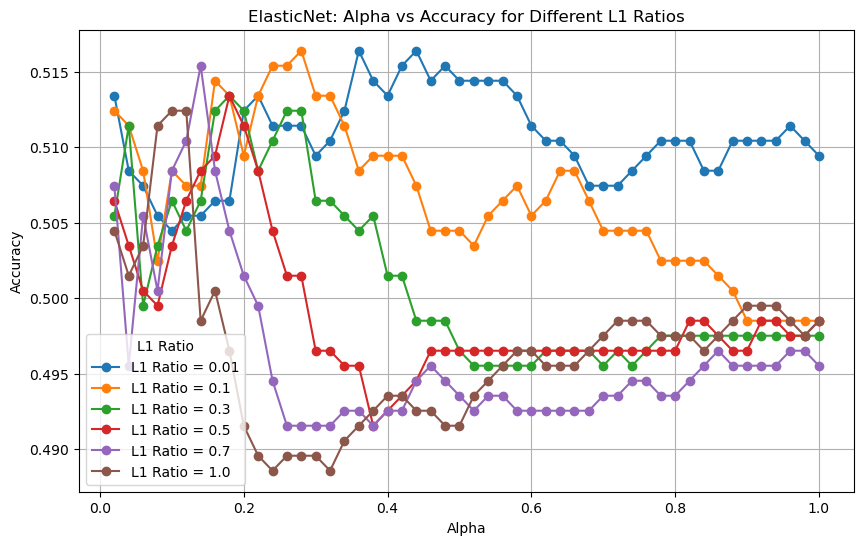

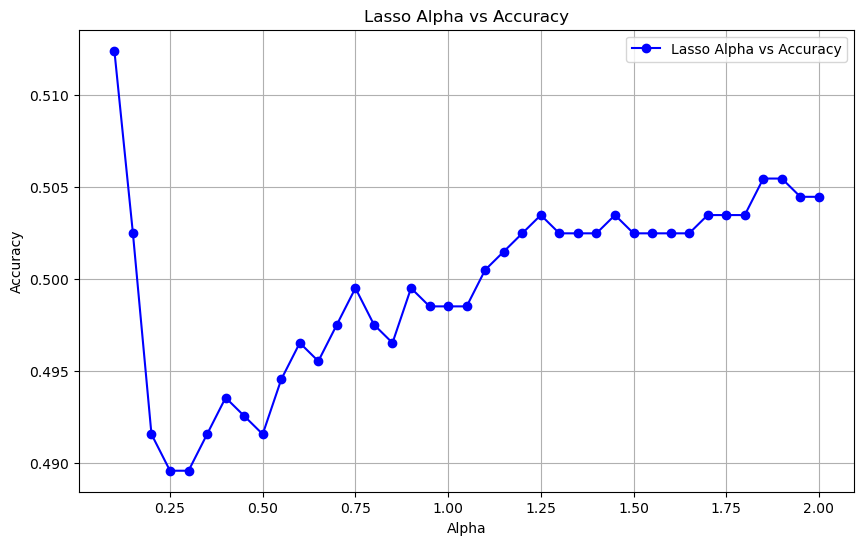

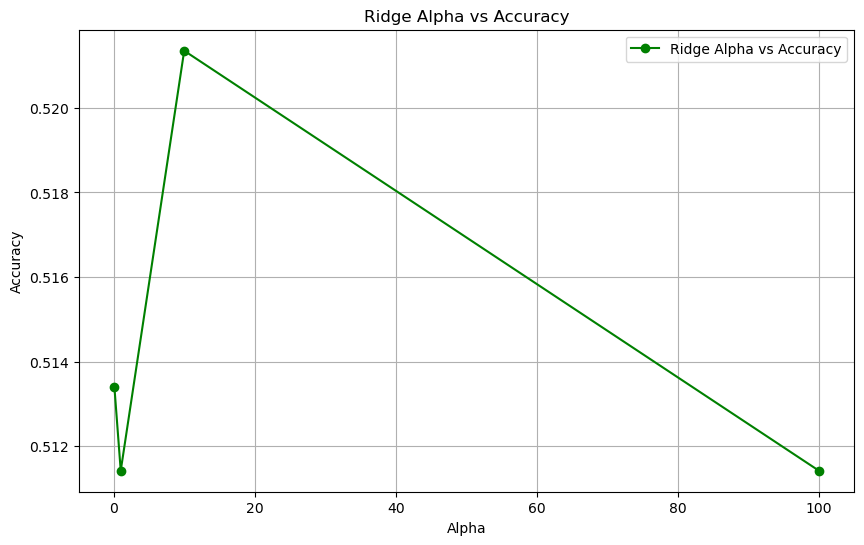

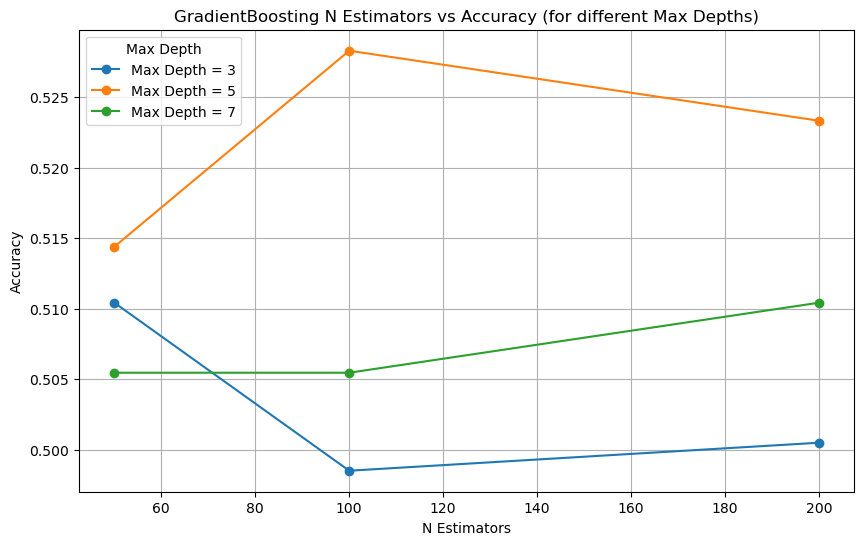

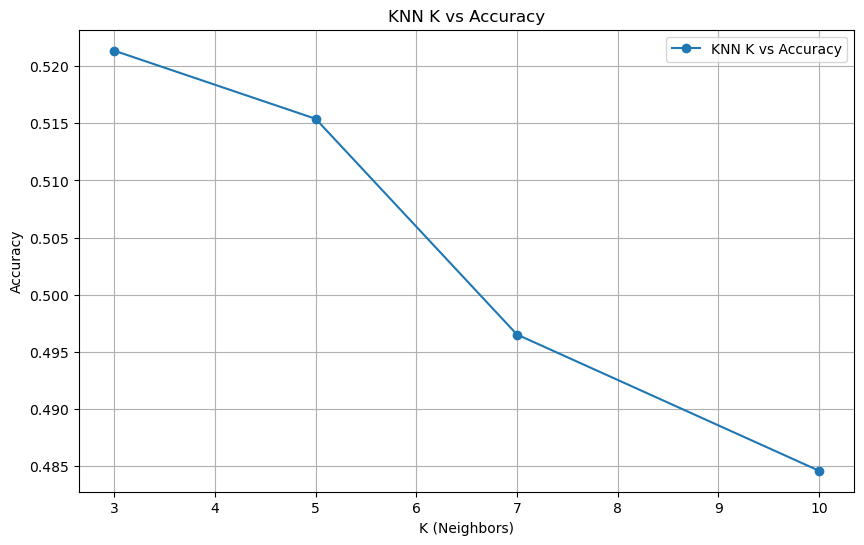

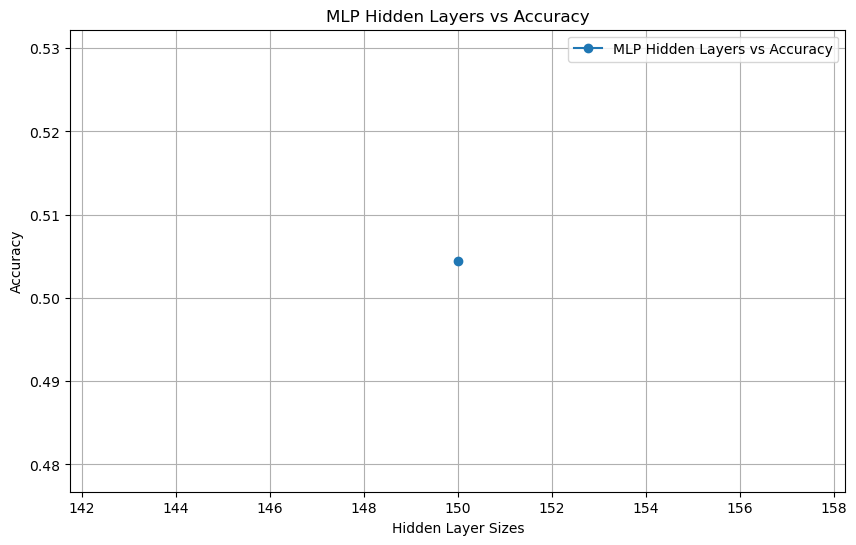

In [44]:
plot_results(results)